In [1]:
import os
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input
from tensorflow.keras.metrics import Precision, Recall

# InceptionV3 Base-model

In [2]:
labels = ['Flooding', 'No Flooding']
train_path = 'MobileNet-CNN/data/train'
valid_path = 'MobileNet-CNN/data/valid'
test_path = 'MobileNet-CNN/data/test'

datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of their height
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in empty pixels during transformations
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 281 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [3]:
inception = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),include_top=False,weights='imagenet')

In [4]:
for layer in inception.layers:
  layer.trainable = False

In [5]:
x = inception.output
x = keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=2, activation='sigmoid')(x)

In [6]:
imodel = Model(inputs=inception.input, outputs=output)

In [7]:
imodel.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [8]:
ihist = imodel.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=12,
          verbose=2
)

Epoch 1/12
29/29 - 5s - loss: 0.7044 - accuracy: 0.5979 - val_loss: 0.6388 - val_accuracy: 0.6119
Epoch 2/12
29/29 - 4s - loss: 0.6006 - accuracy: 0.7011 - val_loss: 0.5705 - val_accuracy: 0.6866
Epoch 3/12
29/29 - 4s - loss: 0.5310 - accuracy: 0.8078 - val_loss: 0.5180 - val_accuracy: 0.8060
Epoch 4/12
29/29 - 4s - loss: 0.4729 - accuracy: 0.8577 - val_loss: 0.4750 - val_accuracy: 0.8060
Epoch 5/12
29/29 - 4s - loss: 0.4263 - accuracy: 0.8754 - val_loss: 0.4377 - val_accuracy: 0.8209
Epoch 6/12
29/29 - 4s - loss: 0.3900 - accuracy: 0.9039 - val_loss: 0.4077 - val_accuracy: 0.8358
Epoch 7/12
29/29 - 4s - loss: 0.3556 - accuracy: 0.9217 - val_loss: 0.3823 - val_accuracy: 0.8657
Epoch 8/12
29/29 - 4s - loss: 0.3281 - accuracy: 0.9217 - val_loss: 0.3610 - val_accuracy: 0.8657
Epoch 9/12
29/29 - 4s - loss: 0.3042 - accuracy: 0.9395 - val_loss: 0.3408 - val_accuracy: 0.8657
Epoch 10/12
29/29 - 4s - loss: 0.2835 - accuracy: 0.9466 - val_loss: 0.3240 - val_accuracy: 0.8955
Epoch 11/12
29/29 -

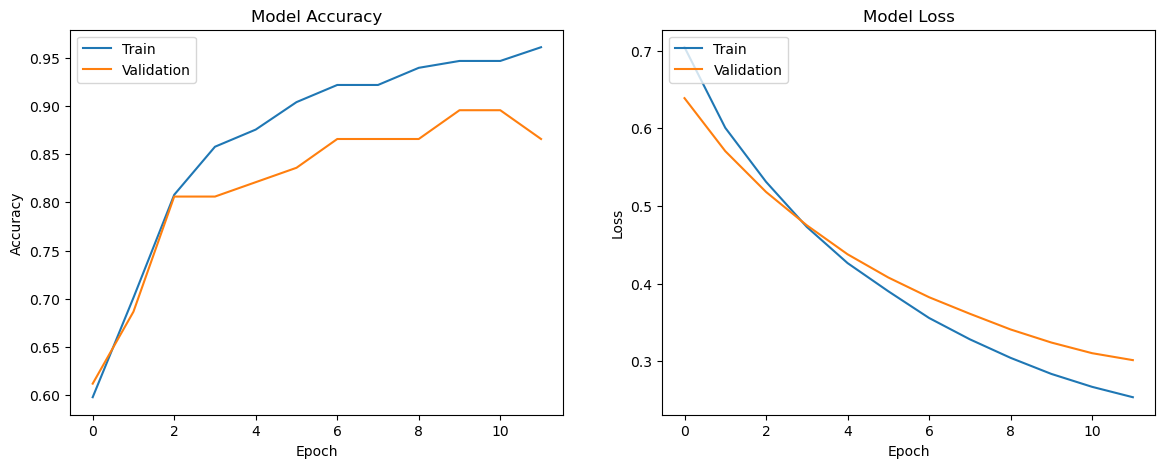

In [9]:
import matplotlib.pyplot as plt

# Fit the model and save the history


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(ihist.history['accuracy'])
plt.plot(ihist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(ihist.history['loss'])
plt.plot(ihist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [10]:
test_labels = test_batches.classes
predictions = imodel.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.875
F1 Score:  0.875
Accuracy:  0.9104477611940298


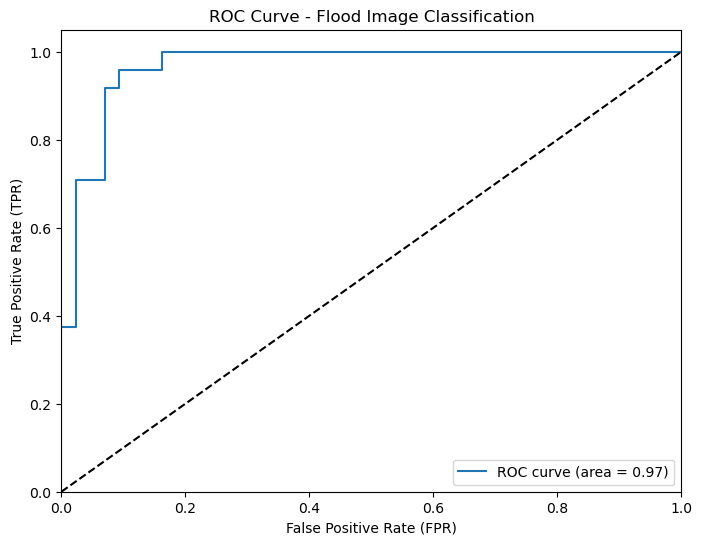

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


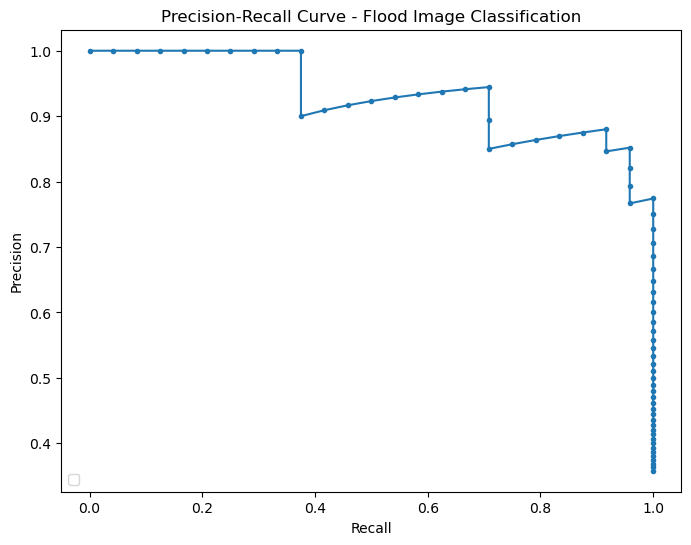

In [12]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get true labels and predicted probabilities
test_labels = test_batches.classes
predictions = imodel.predict(x=test_batches, steps=len(test_batches), verbose=0)

# Calculate false positive rate (FPR) and true positive rate (TPR) for ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])

# Calculate Area Under the Curve (AUC) for ROC curve
roc_auc = auc(fpr, tpr)

# Calculate precision and recall for different thresholds in Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, predictions[:, 1])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Flood Image Classification')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Flood Image Classification')
plt.legend(loc="lower left")
plt.show()


# InceptionV3

In [2]:
labels = ['Flooding', 'No Flooding']
train_path = 'MobileNet-CNN/data/train'
valid_path = 'MobileNet-CNN/data/valid'
test_path = 'MobileNet-CNN/data/test'

datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of their height
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in empty pixels during transformations
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 281 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [3]:
inception = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),include_top=False,weights='imagenet')

In [4]:
x = inception.get_layer('conv2d_60').output
x

<tf.Tensor 'conv2d_60/Conv2D:0' shape=(None, 12, 12, 192) dtype=float32>

In [7]:
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)  # Regularize with dropout
output = Dense(units=2, activation='sigmoid')(x)

In [8]:
model = Model(inputs=inception.input, outputs=output)

In [9]:
count = 0
for layer in model.layers:
    count += 1

In [10]:
count

201

In [11]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
history = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=20,
          verbose=2
)

Epoch 1/20
29/29 - 4s - loss: 0.6581 - accuracy: 0.6121 - val_loss: 0.5643 - val_accuracy: 0.6567
Epoch 2/20
29/29 - 3s - loss: 0.5772 - accuracy: 0.7544 - val_loss: 0.4905 - val_accuracy: 0.7910
Epoch 3/20
29/29 - 4s - loss: 0.4916 - accuracy: 0.7544 - val_loss: 0.4360 - val_accuracy: 0.9104
Epoch 4/20
29/29 - 3s - loss: 0.4477 - accuracy: 0.8719 - val_loss: 0.3892 - val_accuracy: 0.9104
Epoch 5/20
29/29 - 3s - loss: 0.3953 - accuracy: 0.9146 - val_loss: 0.3533 - val_accuracy: 0.9254
Epoch 6/20
29/29 - 4s - loss: 0.3560 - accuracy: 0.9217 - val_loss: 0.3209 - val_accuracy: 0.9254
Epoch 7/20
29/29 - 4s - loss: 0.3327 - accuracy: 0.9253 - val_loss: 0.2944 - val_accuracy: 0.9254
Epoch 8/20
29/29 - 3s - loss: 0.3067 - accuracy: 0.9324 - val_loss: 0.2835 - val_accuracy: 0.9552
Epoch 9/20
29/29 - 3s - loss: 0.2839 - accuracy: 0.9395 - val_loss: 0.2530 - val_accuracy: 0.9552
Epoch 10/20
29/29 - 3s - loss: 0.2677 - accuracy: 0.9466 - val_loss: 0.2359 - val_accuracy: 0.9552
Epoch 11/20
29/29 -

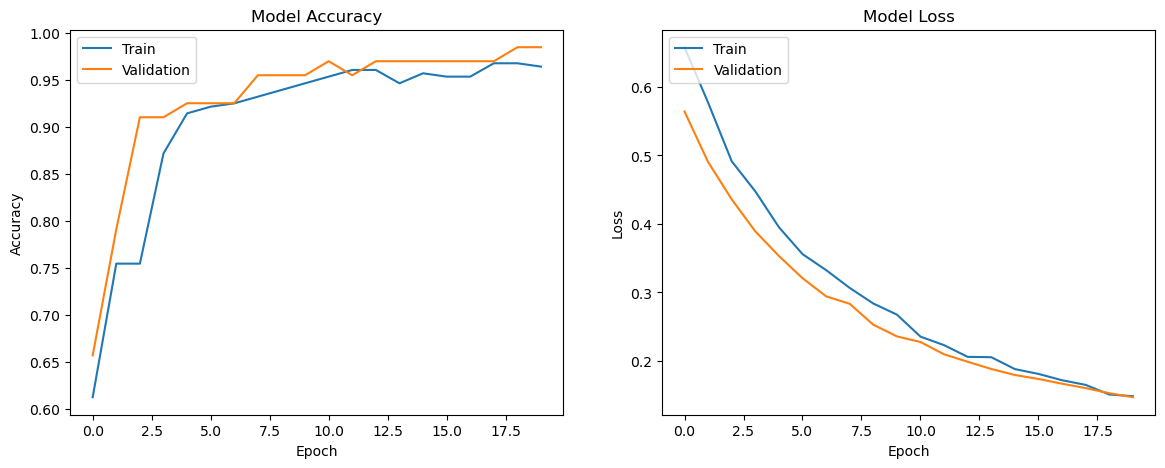

In [14]:
import matplotlib.pyplot as plt

# Fit the model and save the history


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [16]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.9583333333333334
F1 Score:  0.9583333333333334
Accuracy:  0.9701492537313433


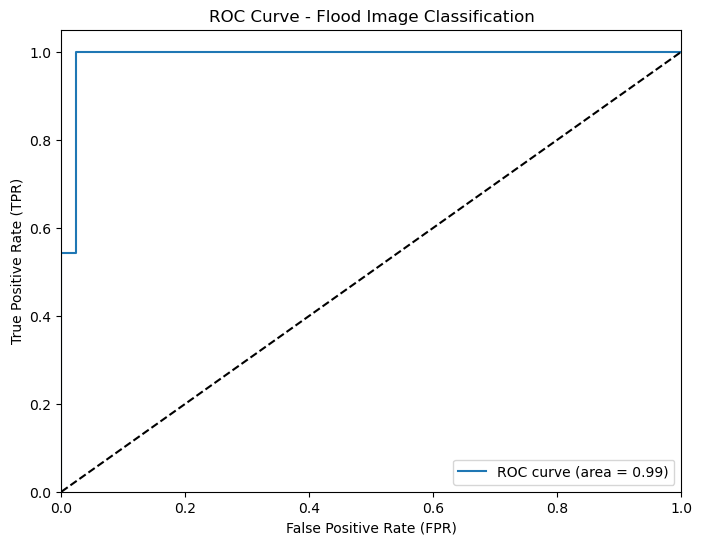

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


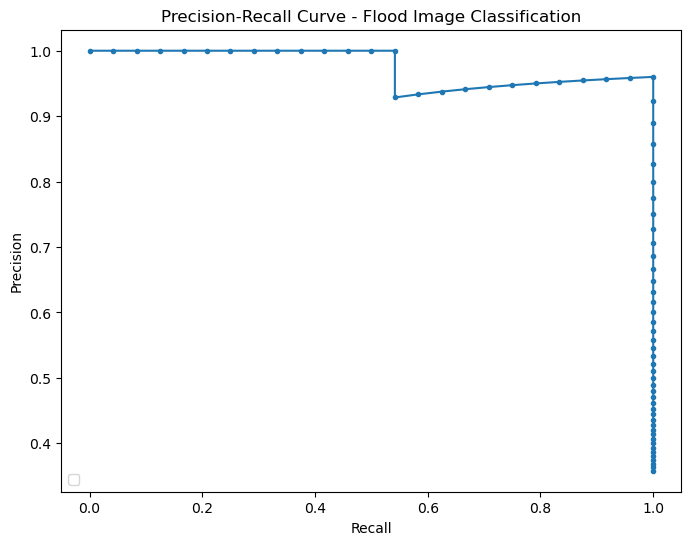

In [18]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get true labels and predicted probabilities
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

# Calculate false positive rate (FPR) and true positive rate (TPR) for ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])

# Calculate Area Under the Curve (AUC) for ROC curve
roc_auc = auc(fpr, tpr)

# Calculate precision and recall for different thresholds in Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, predictions[:, 1])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Flood Image Classification')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Flood Image Classification')
plt.legend(loc="lower left")
plt.show()


# VGG16

In [19]:
labels = ['Flooding', 'No Flooding']
train_path = 'MobileNet-CNN/data/train'
valid_path = 'MobileNet-CNN/data/valid'
test_path = 'MobileNet-CNN/data/test'

datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of their height
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in empty pixels during transformations
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_batches = datagen.flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 281 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [20]:
vgg = tf.keras.applications.VGG16(input_shape=(224, 224,3), weights='imagenet', include_top=False)

In [21]:
for layer in vgg.layers:
  layer.trainable = False

In [22]:
x = vgg.output
x = keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=2, activation='sigmoid')(x)

In [23]:
vmodel = Model(inputs=vgg.input, outputs=output)

In [24]:
vmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [25]:
vhist = vmodel.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=12,
          verbose=2
)

Epoch 1/12
29/29 - 10s - loss: 1.5928 - accuracy: 0.4982 - val_loss: 2.0574 - val_accuracy: 0.4478
Epoch 2/12
29/29 - 9s - loss: 1.4010 - accuracy: 0.5445 - val_loss: 1.8826 - val_accuracy: 0.4478
Epoch 3/12
29/29 - 9s - loss: 1.2378 - accuracy: 0.5516 - val_loss: 1.7706 - val_accuracy: 0.4627
Epoch 4/12
29/29 - 9s - loss: 1.1978 - accuracy: 0.6121 - val_loss: 1.6690 - val_accuracy: 0.4925
Epoch 5/12
29/29 - 10s - loss: 1.1110 - accuracy: 0.6263 - val_loss: 1.5917 - val_accuracy: 0.5522
Epoch 6/12
29/29 - 9s - loss: 1.0566 - accuracy: 0.6157 - val_loss: 1.5347 - val_accuracy: 0.5522
Epoch 7/12
29/29 - 9s - loss: 0.9710 - accuracy: 0.6548 - val_loss: 1.4580 - val_accuracy: 0.6119
Epoch 8/12
29/29 - 9s - loss: 1.0109 - accuracy: 0.6762 - val_loss: 1.3942 - val_accuracy: 0.6716
Epoch 9/12
29/29 - 10s - loss: 0.9069 - accuracy: 0.7011 - val_loss: 1.3330 - val_accuracy: 0.6716
Epoch 10/12
29/29 - 9s - loss: 0.8805 - accuracy: 0.7082 - val_loss: 1.2881 - val_accuracy: 0.6866
Epoch 11/12
29/2

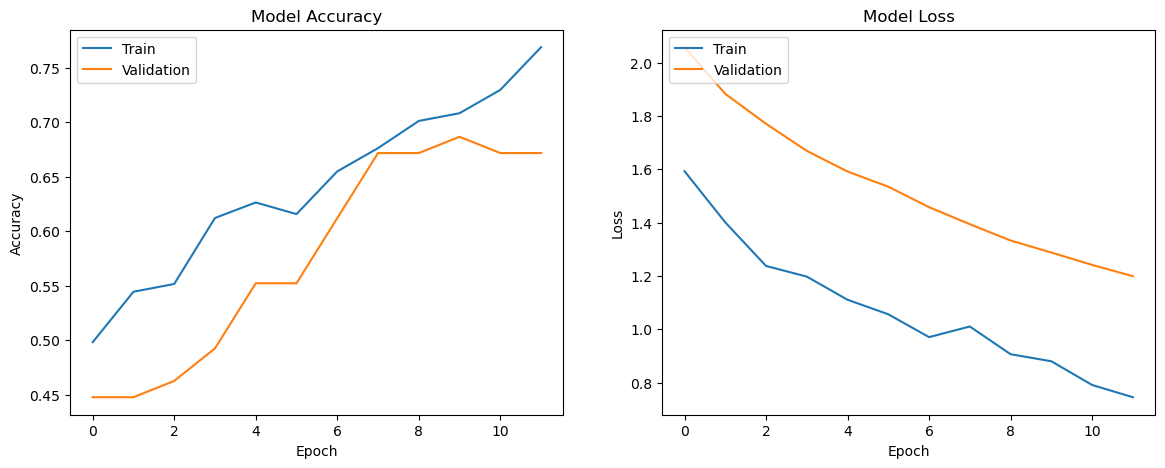

In [26]:
import matplotlib.pyplot as plt

# Fit the model and save the history


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(vhist.history['accuracy'])
plt.plot(vhist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(vhist.history['loss'])
plt.plot(vhist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [28]:

from sklearn.metrics import f1_score
test_labels = test_batches.classes
predictions = vmodel.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.6774193548387096
F1 Score:  0.7636363636363636
Accuracy:  0.8059701492537313


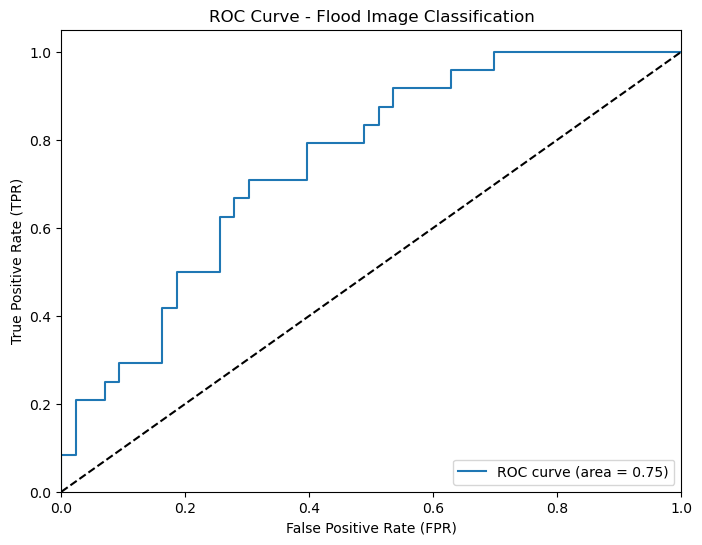

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


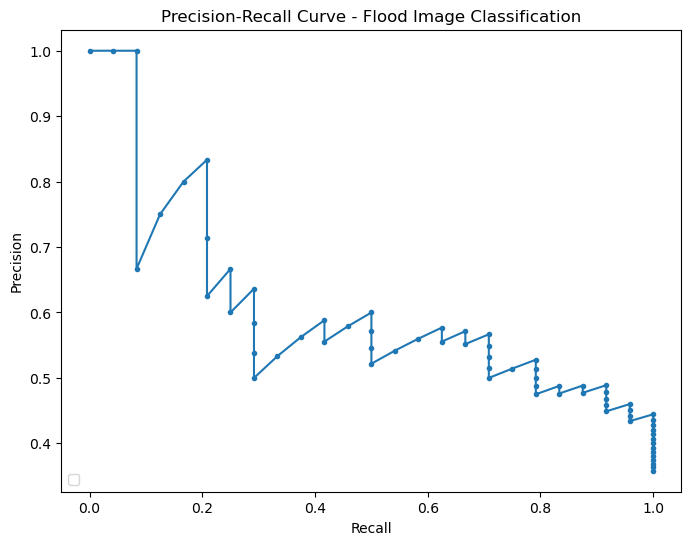

In [30]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get true labels and predicted probabilities
test_labels = test_batches.classes
predictions = vmodel.predict(x=test_batches, steps=len(test_batches), verbose=0)

# Calculate false positive rate (FPR) and true positive rate (TPR) for ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])

# Calculate Area Under the Curve (AUC) for ROC curve
roc_auc = auc(fpr, tpr)

# Calculate precision and recall for different thresholds in Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, predictions[:, 1])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Flood Image Classification')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Flood Image Classification')
plt.legend(loc="lower left")
plt.show()


# ResNet50

In [31]:
labels = ['Flooding', 'No Flooding']
train_path = 'MobileNet-CNN/data/train'
valid_path = 'MobileNet-CNN/data/valid'
test_path = 'MobileNet-CNN/data/test'

datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of their height
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in empty pixels during transformations
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_batches = datagen.flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 281 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [32]:
res = tf.keras.applications.ResNet50(input_shape=(224, 224,3), weights='imagenet', include_top=False)

In [33]:
for layer in res.layers:
  layer.trainable = False

In [34]:
x = res.output
x = keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=2, activation='sigmoid')(x)

In [35]:
rmodel = Model(inputs=res.input, outputs=output)

In [36]:
rmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [37]:
rhist = rmodel.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=12,
          verbose=2
)

Epoch 1/12
29/29 - 7s - loss: 0.8043 - accuracy: 0.6833 - val_loss: 0.6286 - val_accuracy: 0.6866
Epoch 2/12
29/29 - 7s - loss: 0.6168 - accuracy: 0.7224 - val_loss: 0.5397 - val_accuracy: 0.7015
Epoch 3/12
29/29 - 6s - loss: 0.5491 - accuracy: 0.7722 - val_loss: 0.4863 - val_accuracy: 0.7164
Epoch 4/12
29/29 - 6s - loss: 0.4799 - accuracy: 0.8327 - val_loss: 0.4304 - val_accuracy: 0.7910
Epoch 5/12
29/29 - 6s - loss: 0.4177 - accuracy: 0.8897 - val_loss: 0.3840 - val_accuracy: 0.8657
Epoch 6/12
29/29 - 6s - loss: 0.3775 - accuracy: 0.8932 - val_loss: 0.3364 - val_accuracy: 0.8955
Epoch 7/12
29/29 - 6s - loss: 0.3541 - accuracy: 0.9181 - val_loss: 0.3039 - val_accuracy: 0.8955
Epoch 8/12
29/29 - 6s - loss: 0.3220 - accuracy: 0.9217 - val_loss: 0.2798 - val_accuracy: 0.8955
Epoch 9/12
29/29 - 6s - loss: 0.2944 - accuracy: 0.9324 - val_loss: 0.2625 - val_accuracy: 0.8955
Epoch 10/12
29/29 - 6s - loss: 0.2811 - accuracy: 0.9466 - val_loss: 0.2483 - val_accuracy: 0.9104
Epoch 11/12
29/29 -

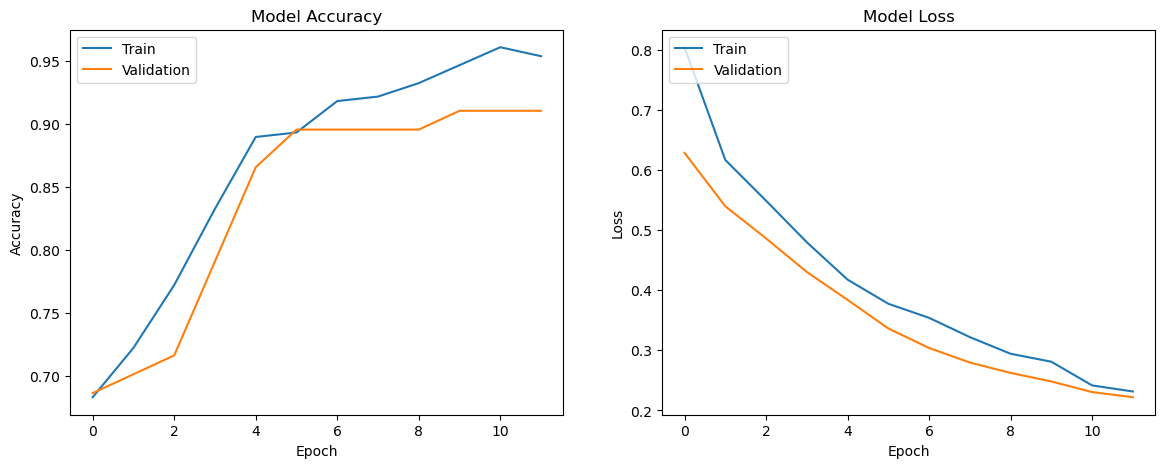

In [38]:
import matplotlib.pyplot as plt

# Fit the model and save the history


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(rhist.history['accuracy'])
plt.plot(rhist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(rhist.history['loss'])
plt.plot(rhist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [39]:
from sklearn.metrics import f1_score

test_labels = test_batches.classes
predictions = rmodel.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.9523809523809523
F1 Score:  0.888888888888889
Accuracy:  0.9253731343283582


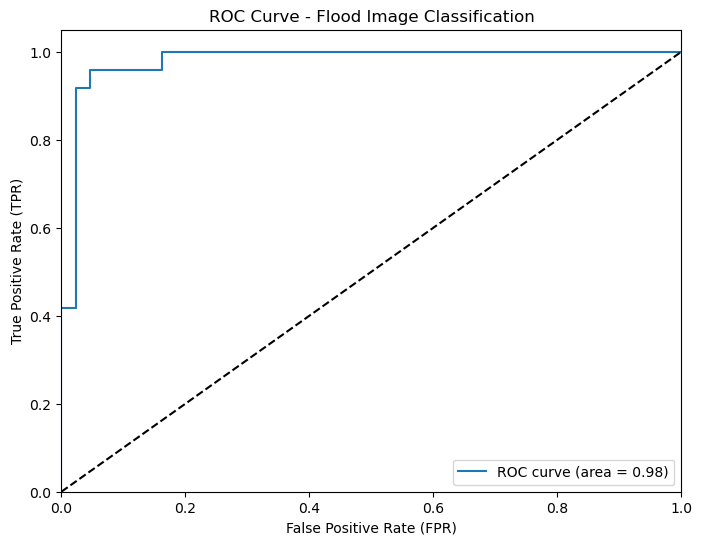

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


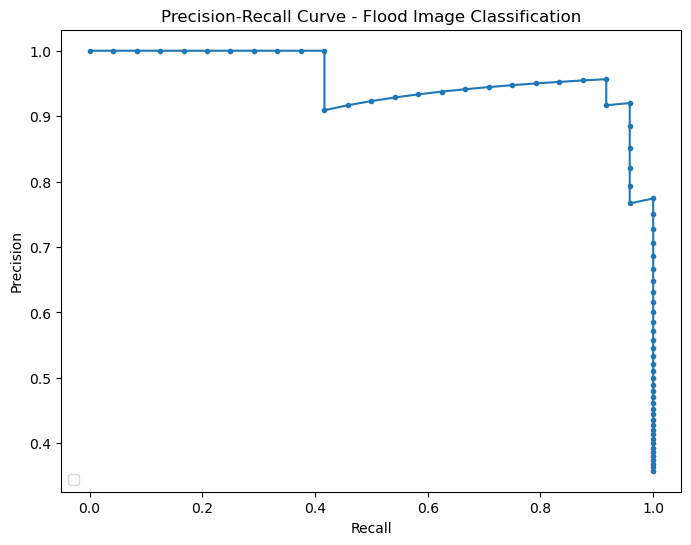

In [41]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get true labels and predicted probabilities
test_labels = test_batches.classes
predictions = rmodel.predict(x=test_batches, steps=len(test_batches), verbose=0)

# Calculate false positive rate (FPR) and true positive rate (TPR) for ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])

# Calculate Area Under the Curve (AUC) for ROC curve
roc_auc = auc(fpr, tpr)

# Calculate precision and recall for different thresholds in Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, predictions[:, 1])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Flood Image Classification')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Flood Image Classification')
plt.legend(loc="lower left")
plt.show()


# MobileNet

In [42]:
labels = ['Flooding', 'No Flooding']
train_path = 'MobileNet-CNN/data/train'
valid_path = 'MobileNet-CNN/data/valid'
test_path = 'MobileNet-CNN/data/test'

datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of their height
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in empty pixels during transformations
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
)

train_batches = datagen.flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 281 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [43]:
mobile = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224,3), weights='imagenet', include_top=False)

In [44]:
for layer in mobile.layers:
  layer.trainable = False

In [45]:
x = mobile.output
x = keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=2, activation='sigmoid')(x)

In [46]:
mmodel = Model(inputs=mobile.input, outputs=output)

In [47]:
mmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [48]:
mhist = mmodel.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=12,
          verbose=2
)

Epoch 1/12
29/29 - 4s - loss: 0.9462 - accuracy: 0.3701 - val_loss: 0.8329 - val_accuracy: 0.4478
Epoch 2/12
29/29 - 3s - loss: 0.7617 - accuracy: 0.5302 - val_loss: 0.7262 - val_accuracy: 0.5672
Epoch 3/12
29/29 - 4s - loss: 0.6767 - accuracy: 0.6085 - val_loss: 0.6764 - val_accuracy: 0.7015
Epoch 4/12
29/29 - 3s - loss: 0.6533 - accuracy: 0.7046 - val_loss: 0.6294 - val_accuracy: 0.7313
Epoch 5/12
29/29 - 3s - loss: 0.5987 - accuracy: 0.7153 - val_loss: 0.5913 - val_accuracy: 0.7463
Epoch 6/12
29/29 - 3s - loss: 0.5816 - accuracy: 0.7580 - val_loss: 0.5552 - val_accuracy: 0.8209
Epoch 7/12
29/29 - 4s - loss: 0.5402 - accuracy: 0.7900 - val_loss: 0.5200 - val_accuracy: 0.8358
Epoch 8/12
29/29 - 4s - loss: 0.5248 - accuracy: 0.8078 - val_loss: 0.4958 - val_accuracy: 0.8806
Epoch 9/12
29/29 - 4s - loss: 0.4927 - accuracy: 0.8292 - val_loss: 0.4662 - val_accuracy: 0.8806
Epoch 10/12
29/29 - 3s - loss: 0.4677 - accuracy: 0.8256 - val_loss: 0.4382 - val_accuracy: 0.8507
Epoch 11/12
29/29 -

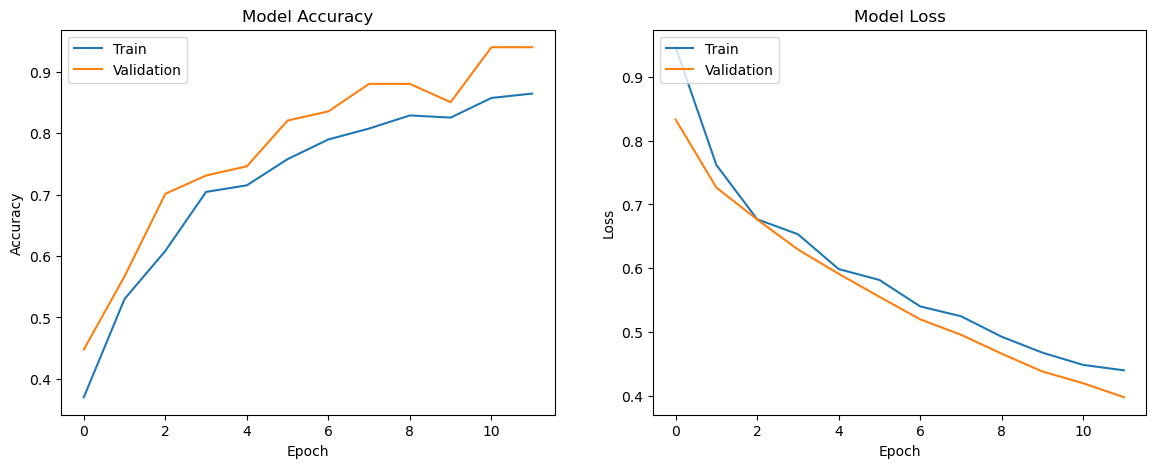

In [49]:
import matplotlib.pyplot as plt

# Fit the model and save the history


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(mhist.history['accuracy'])
plt.plot(mhist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(mhist.history['loss'])
plt.plot(mhist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [50]:
from sklearn.metrics import f1_score

test_labels = test_batches.classes
predictions = mmodel.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [51]:
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.9130434782608695
F1 Score:  0.8936170212765957
Accuracy:  0.9253731343283582


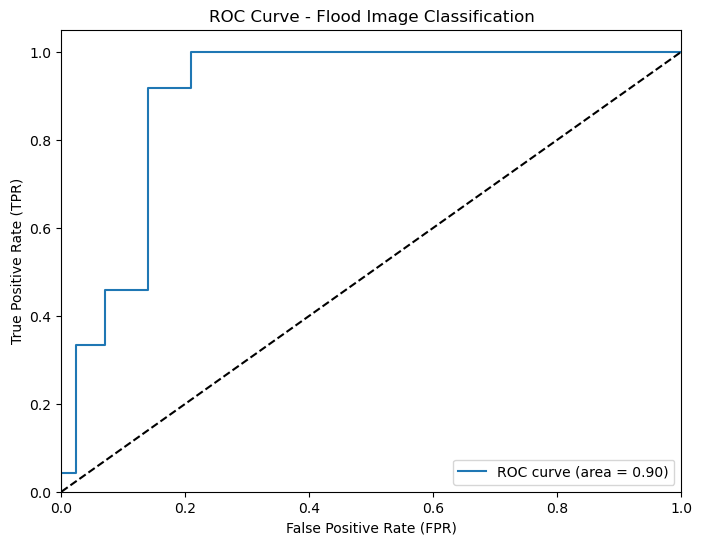

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


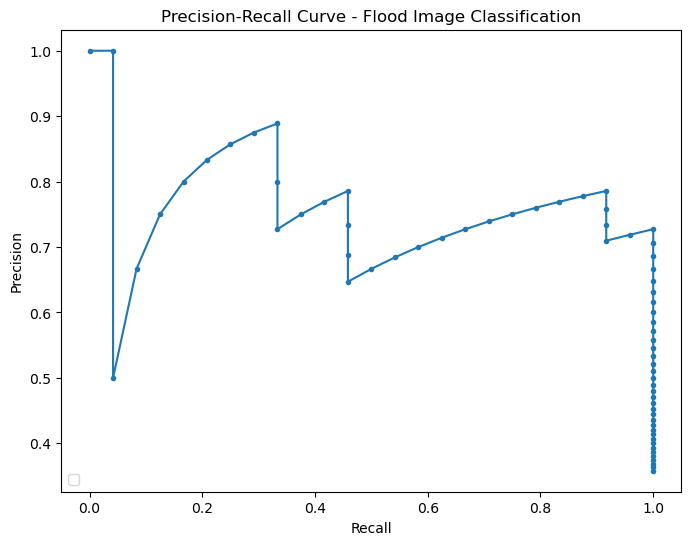

In [54]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get true labels and predicted probabilities
test_labels = test_batches.classes
predictions = mmodel.predict(x=test_batches, steps=len(test_batches), verbose=0)

# Calculate false positive rate (FPR) and true positive rate (TPR) for ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])

# Calculate Area Under the Curve (AUC) for ROC curve
roc_auc = auc(fpr, tpr)

# Calculate precision and recall for different thresholds in Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, predictions[:, 1])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Flood Image Classification')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Flood Image Classification')
plt.legend(loc="lower left")
plt.show()
